# Speeding up numerical Python code

### A guide with astromical examples
by Bjoern Soergel, Institute of Astronomy, Cambridge, UK 

## Some general remarks:

Here is the procedure I would recommend for optimizing a piece of numerical code.

- Remember the 80/20 principle: For a typical code, 80% of the runtime will be spent in at most 20% of the code. Don't waste your time optimizing anything but the critical 20%. 
- Profile your code to find out what the bottleneck is. In Jupyter notebooks, we can e.g. use the %timeit and %%time magic for that.
- Before you start coding, think/research if there is a better algorithm of doing the same thing. Again, we don't want to waste our time optimizing a bad algorithm.
- Don't parallelize blindly, first optimize on a single CPU.
- Check carefully that the optimized version still gives the same result.

For the sake of this tutorial we focus exclusively on optimizing a given piece of code, but profiling and the algorithm are equally important!

## Some Python-specific advice.
 - Avoid nested for loops in numerical computations.
 - Use numpy/scipy/.. built-ins wherever possible. They are vectorized and internally written in C or Fortran/Cython and therefore super-fast in most cases.
 - The aim of this tutorial is to show what do to in cases where numpy/scipy/... built-ins are either not sufficient.

## Part 1: Worked example: Contaminant removal on the sphere

Here we mostly focus on performance on a single CPU (with one exception). The second part will show how to parallelize generic Python code.

#### Setup:
- one catalogue with coordinates of objects of interest
- second catalogue with coordinates of contaminants
- want to flag all objects of interest that are closer than a certain angular distance to a contaminant object

NB: There are built-in functions in scipy and astropy to do exactly this computation, but that's not the point here. 

## Setup: generate random points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#helper function to generate points
def gen_points_sphere(n):
    """
    generate random points on sphere
    """
    #angles
    costheta = 2*np.random.rand(n)-1
    theta = np.arccos(costheta)
    phi = 2*np.pi*np.random.rand(n)
    #unit vectors on the sphere
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    vec = np.array([x,y,z]).T
    return vec,theta,phi

n = 100000
vec,theta,phi = gen_points_sphere(n)

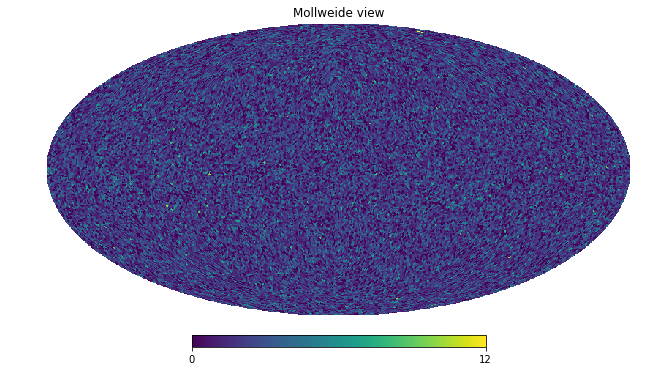

In [3]:
#sky plot of points, just for visualization, can be commented
import healpy as hp
def skymap(theta,phi,nside): 
    """
    creates healpix map of density on the sky
    """
    ipix = hp.ang2pix(nside,theta,phi)
    testmap = np.bincount(ipix,minlength=hp.nside2npix(nside))
    return testmap
        
testmap = skymap(theta,phi,64)
hp.mollview(testmap)

In [4]:
#generate populations for example
# objects (obj)
vec_obj,theta_obj,phi_obj = gen_points_sphere(5000) # ~500,000 in my real use case
# contaminants (ps)
vec_ps,theta_ps,phi_ps = gen_points_sphere(500) # ~50,000 in my real use case
print(vec_obj.shape,vec_ps.shape)
# maximum separation: 
maxsep_deg = 1.
cos_maxsep = np.cos(np.deg2rad(maxsep_deg))

(5000, 3) (500, 3)


## Algorithms

Before we start coding and optimizing, we should first think of a good algorithm for our problem.

#### 1) obvious first idea: great circle distance
- compute great circle distance $\Delta \sigma$ between all pairs (e.g. https://en.wikipedia.org/wiki/Great-circle_distance). 
- requires $ \sim (5~\mathrm{to}~10) \times N_{obj} \times N_{ps}$ evaluations of trigonometric functions
- slow for large $N$

#### 2) better: dot product
- If we represent our points by 3D unit vectors, then $ \cos (\Delta \sigma) = \bf{n}_1 \dot \bf{n}_2$ 
- compute only one dot product per pair

#### 3) even better for large $N$: k-d tree 
- See e.g. https://en.wikipedia.org/wiki/K-d_tree. This is what the astropy version uses internally. 
- But for the sake of having an example that is easy to implement, let's stick with the dot product (2).

## Implementations

### 0) Astropy

We'll use the astropy version as a check that our implementations give the correct answer. 

NB: Comparing timings is however only of limited use because this version uses a different algorithm and does more.

In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u

def angdistcut_astropy(theta_obj,phi_obj,theta_ps,phi_ps,cos_maxsep):
    """
    wrapper around astropy catalogue matching
    """
    ra_obj = np.rad2deg(phi_obj)
    dec_obj = 90.-np.rad2deg(theta_obj)
    ra_ps = np.rad2deg(phi_ps)
    dec_ps = 90.-np.rad2deg(theta_ps)
    #create two catalogue objects
    c_obj = SkyCoord(ra=ra_obj*u.degree, dec=dec_obj*u.degree)  
    c_ps = SkyCoord(ra=ra_ps*u.degree, dec=dec_ps*u.degree)  
    #nearest neighbour match (internally used kd-tree)
    idx, d2d, d3d = c_obj.match_to_catalog_sky(c_ps)
    #pick objects within separation
    out = np.where(d2d < maxsep_deg*u.degree)[0]
    return out

In [6]:
%%time
result_astropy = angdistcut_astropy(theta_obj,phi_obj,theta_ps,phi_ps,cos_maxsep)

CPU times: user 70 ms, sys: 6 ms, total: 76 ms
Wall time: 140 ms


Now let's start implementing a solution for this problem ourselves.

### 1) Naive Python
(we all know that for loops in Python are slow)

NB: For convenience we are still using numpy arrays as input and output (we could do the same with lists though). The core of the computation is however in pure Python.

In [7]:
def angdistcut_python_naive(vec_obj,vec_ps,cos_maxsep):
    nobj = vec_obj.shape[0]
    nps = vec_ps.shape[0]
    dim = vec_obj.shape[1]
    #objects to be deleted
    out = []
    for i in range(nobj):
        for j in range(nps):
            cos = 0.
            #compute dot product
            for k in range(dim):
                cos += vec_obj[i,k] * vec_ps[j,k]
            #stop once we have found one contaminant
            if cos > cos_maxsep:
                out.append(i)
                break   
    return np.array(out)

In [8]:
%%time
result_python_naive = angdistcut_python_naive(vec_obj,vec_ps,cos_maxsep)

CPU times: user 2.82 s, sys: 5 ms, total: 2.83 s
Wall time: 2.83 s


In [9]:
#checking result
assert np.array_equal(result_astropy,result_python_naive)

In [10]:
# projected runtime (roughly) for real case scenario (100x more objects and contaminants), in hours
3*100*100/3600.

8.333333333333334

Maybe this is still OK if it is a one-off, but prohibitively slow if one wants to run this on many samples, test different cuts, etc..

#### NB: All timing-related statements may vary slightly because I wrote this on the work desktop. We will see further down the line that some things are indeed platform dependent.

### 2) Numpy

In [11]:
def angdistcut_numpy(vec_obj,vec_ps,cos_maxsep):
    nobj = vec_obj.shape[0]
    nps = vec_ps.shape[0]
    # fast vectorized way to compute dot product
    # (looses the advantage of stopping once one contaminant is found)
    # (but the numpy speed gains easily outweigh that)
    cos_arr = np.einsum('ik,jk->ij',vec_obj,vec_ps)
    # number of contaminants per object
    temp = (cos_arr > cos_maxsep).sum(axis=1)
    #indices of objects that should be removed
    out = np.flatnonzero(temp)
    return out

In [12]:
%%time
result_numpy = angdistcut_numpy(vec_obj,vec_ps,cos_maxsep)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 15.2 ms


In [13]:
# check that results agree
assert np.array_equal(result_python_naive,result_numpy)

- Using numpy has given us a speed-up of a factor of ~200, which is quite typical for computations that can be vectorized efficiently.

- For this small example, our numpy version is also faster than the version using astropy. But that is not a fair comparison, because (1) the astropy version does the entire catalogue matching, (2) they use a different algorithm.

Can we stop here? in a lot of cases, yes. 

In [14]:
# expected runtime for full sample
12e-3*100*100/3600. #hours

0.03333333333333333

However, we have not considered memory usage so far. For its vectorized computation to be efficient, numpy has to store everything in large arrays that are contiguous in memory. Simply to store the intermediate array *cos_arr* we need at least:

In [15]:
# double precision (64 bit = 8 byte per element)
# Nobj*Nps*8 
5e5*5e4*8/1e9 #in GB

200.0

Our work desktops have 16 GB, so suddenly memory becomes the bottleneck. As soon as things need to be swapped from memory to the hard drive, things become *really* slow.

On top, some numpy functions allocate larger temporary arrays "behind the scenes", making this problem even worse. 

## Enter: python optimization tools:
- *numba* (numpy-aware just-in-time compiler)
- *Cython* (Python/C hybrid language, creates compiled C extension)

From my experience, the two above are the most mature and useful ones, but there are certainly other options, such as:
- other JIT compilers (Hope, Pythran, PyPy,...)
- scipy weave (importing C code into python)
- ctypes (Python/C API for C extensions)
- f2py (Fortran --> Python modules)
- ...

NB: The latter three require you to write C/C++ or Fortran code. If you are proficient in either of these, you might not run into the issue of having to optimize numerical Python code so frequently. It might still be worth learning, as Python (and also Cython) are much nicer to write than C/C++ or Fortran.

### 3) Numba:

Numba takes our Python code and translates it to fast machine code the first time we call a function (just-in-time). All we need to do is to add the @jit decorator.

For it to work well, we should write out our loops (as in the naive Python version). Credit: Stackoverflow (user John Greenall).

In [16]:
#almost identical to our naive python implementation
from numba import jit
@jit
def angdistcut_numba(vec_obj, vec_ps, cos_maxsep):
    nps = vec_ps.shape[0]
    nobj = vec_obj.shape[0]
    dim = vec_obj.shape[1]
    #use array instead of list here, otherwise numba throws error
    found = np.zeros(nobj, np.bool_)
    for i in range(nobj):
        for j in range(nps):
            cos = 0.0
            #compute dot product
            for k in range(dim):
                cos += vec_obj[i,k] * vec_ps[j,k]
            if cos > cos_maxsep:
                found[i] = True
                break
    return np.flatnonzero(found)

NB: The first time we call the numba function, there will be an overhead for the JIT compilation

In [17]:
%%time
result_numba = angdistcut_numba(vec_obj,vec_ps,cos_maxsep)

CPU times: user 190 ms, sys: 10 ms, total: 200 ms
Wall time: 254 ms


In [18]:
%%time
result_numba = angdistcut_numba(vec_obj,vec_ps,cos_maxsep)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.93 ms


In [19]:
assert np.array_equal(result_numba,result_numpy)

This is another factor of 3 faster than the numpy version, and around 600 times faster than the original. And this was for essentially no effort, just adding one decorator and letting numba do its job.

In [20]:
# let's have a look at the memory footprint
# (for now can simply use "top" in a separate terminal):
vec_obj_new,_,_ = gen_points_sphere(500000)
vec_ps_new,_,_ = gen_points_sphere(50000)
test = angdistcut_numba(vec_obj_new,vec_ps_new,cos_maxsep)

The memory problems are solved, as expected (no large arrays allocated behind the scenes). Can we stop here? For most cases probably yes. 

But let's try to optimize it a bit further:

In [21]:
# Further numba optimization
def angdistcut_numba_opt(vec_obj, vec_ps, cos_maxsep):
    nps = len(vec_ps)
    nobj = len(vec_obj)
    out = np.zeros(nobj, bool)
    numba3_helper(vec_obj, vec_ps, cos_maxsep, out, nps, nobj)
    return np.flatnonzero(out)
    
@jit(nopython=True)
def numba3_helper(vec_obj, vec_ps, cos_maxsep, out, nps, nobj):
    for i in range(nobj):
        for j in range(nps):
            cos = (vec_obj[i,0]*vec_ps[j,0] + 
                   vec_obj[i,1]*vec_ps[j,1] + 
                   vec_obj[i,2]*vec_ps[j,2])
            if cos > cos_maxsep:
                out[i] = True
                break
    return out   

Changes:
- separated computation and helper functions
- specified ndim = 3
- added "nopython=True" option to decorator

Again there will be a small overhead when using the function for the first time.

In [22]:
%%time
result_numba_opt = angdistcut_numba_opt(vec_obj,vec_ps,cos_maxsep)

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 75.8 ms


In [23]:
%%time
result_numba_opt = angdistcut_numba(vec_obj,vec_ps,cos_maxsep)

CPU times: user 7 ms, sys: 0 ns, total: 7 ms
Wall time: 6.04 ms


Another small speedup (on my work desktop), leaving us 2x faster than numpy and >1000x faster than the original Python. 

NB: How much speed-up this brings might be platform dependent.

- But why do these changes help? It's hard to tell, because numba does its job completely behind the scenes. It would be nice to have more control over the optimization.

- Also, default numba only uses one of the 8 available cores. (NB: Parallelization is possible via the threading module, but it is a bit of work to set it up, e.g. http://numba.pydata.org/numba-doc/0.15.1/examples.html#multi-threading, http://roman-kh.github.io/numba-2/)

#### Cython solves both of these problems (more transparent optimization, easy parallelization via Open-MP)

### 4) Cython

Cython is a super-set of Python. It allows static type definitions, translates our Python code into C code, which we can then compile and then import as an external library (.so on linux) back into Python.

In Jupyter notebooks, all this can be done automatically behind the scenes. 

Outside of Jupyter notebooks, we need to write a very short Python Makefile that handles the compilation for us, see e.g. here:
http://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html

In [24]:
%load_ext Cython

#### Start: a cythonized version of the naive pure-Python implementation

In [25]:
%%cython -a
# -a provides annotation
# yellow annotations: calls to Python --> slow
# want to remove all yellow from our loops

#Python functions,attributes from numpy
import numpy as np
# C functions,attributes
cimport numpy as np
# Cython handles the namespace ambiguity internally in this case

def angdistcut_cython_naive(vec_obj, vec_ps, cos_maxsep):
    nps = vec_ps.shape[0]
    nobj = vec_obj.shape[0]
    dim = vec_obj.shape[1]
    #use array instead of list here, otherwise numba throws error
    found = np.zeros(nobj, np.bool_)
    for i in range(nobj):
        for j in range(nps):
            cos = 0.0
            #compute dot product
            for k in range(dim):
                cos += vec_obj[i,k] * vec_ps[j,k]
            if cos > cos_maxsep:
                found[i] = True
                break
    return np.flatnonzero(found)

In [26]:
%%time
result_cython_naive = angdistcut_cython_naive(vec_obj,vec_ps,cos_maxsep)

CPU times: user 2.33 s, sys: 0 ns, total: 2.33 s
Wall time: 2.32 s


In [27]:
assert np.array_equal(result_cython_naive,result_numpy)

Essentially all Python code is valid Cython code. But without adding type definitions we get only a very small speed-up.

#### Adding static type definitions

In [28]:
%%cython -a

import numpy as np
cimport numpy as np

def angdistcut_cython_typed(double[:,::1] vec_obj, double[:,::1] vec_ps, double cos_maxsep):
    """
    NB: double[:] --> "typed memoryview": gives fast access to numpy-like arrays in Cython
    double[:,::1] --> 2D typed memoryview, with last index varying fastest
    for this it needs to be C contigous
    """
    
    cdef:
        int nps = vec_ps.shape[0]
        int nobj = vec_obj.shape[0]
        int dim = vec_obj.shape[1]
        #use int array instead of bool
        int[:] found = np.zeros(nobj, np.int32)
        int i,j
        double cos

    for i in range(nobj):
        for j in range(nps):
            cos = (vec_obj[i,0]*vec_ps[j,0] + 
                   vec_obj[i,1]*vec_ps[j,1] + 
                   vec_obj[i,2]*vec_ps[j,2])
            if cos > cos_maxsep:
                found[i] = 1
                break
    #convert result from typed memory view into array before returning            
    return np.flatnonzero(np.asarray(found))

In [29]:
#change memory ordering
vec_obj_c = np.ascontiguousarray(vec_obj)
vec_ps_c = np.ascontiguousarray(vec_ps)
#this is not always necessary, but here it is because of the way we have created the arrays

In [30]:
%%time
result_cython_typed = angdistcut_cython_typed(vec_obj_c,vec_ps_c,cos_maxsep)

CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 13.3 ms


In [31]:
assert np.array_equal(result_cython_typed,result_numpy)

With a little typing effort, we already beat numpy, but are still slower than the optimized numba version.

NB: again, this statement is somewhat platform dependent

#### Let's add some compiler directives to optimize our Cython function.

In [32]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def angdistcut_cython_opt(double[:,::1] vec_obj, double[:,::1] vec_ps, double cos_maxsep):
    """
    disabled some of the run-time checks, and also enabled C division
    the latter is pointless here, but can make large differences when divisions are involved
    full overview:
    http://cython.readthedocs.io/en/latest/src/reference/compilation.html#compiler-directives
    """
    
    cdef:
        int nps = vec_ps.shape[0]
        int nobj = vec_obj.shape[0]
        int dim = vec_obj.shape[1]
        #use int array instead of bool
        int[:] found = np.zeros(nobj, np.int32)
        int i,j
        double cos

    for i in range(nobj):
        for j in range(nps):
            cos = (vec_obj[i,0]*vec_ps[j,0] + 
                   vec_obj[i,1]*vec_ps[j,1] + 
                   vec_obj[i,2]*vec_ps[j,2])
            if cos > cos_maxsep:
                found[i] = 1
                break
                
    return np.flatnonzero(np.asarray(found))

In [33]:
%%time
result_cython_opt = angdistcut_cython_opt(vec_obj_c,vec_ps_c,cos_maxsep)

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.34 ms


In [34]:
assert np.array_equal(result_cython_opt,result_numpy)

By adding the decorators Cython now runs at equal speed with, or somewhat faster than, numba.


- Cython disadvantage: We had to put in more work. If all you want to do is speed up this one loop, you might not need to go further than numba.

- Cython advantage 1: more transparent, therefore allows for better user control and optimization.

- Cython advantage 2: easy parallelization, see below.




#### Now with OMP-parallelization:

In [35]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp

import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange, parallel

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def angdistcut_cython_par(double[:,::1] vec_obj, double[:,::1] vec_ps, double cos_maxsep, int num_threads):
    """
    added extra compiler flags
    also added a new argument for the number of threads
    """
    
    cdef:
        int nps = vec_ps.shape[0]
        int nobj = vec_obj.shape[0]
        int dim = vec_obj.shape[1]
        #use int array instead of bool
        int[:] found = np.zeros(nobj, np.int32)
        int i,j
        double cos

    #every object is independent, so can parallelize the outer loop easily
    # need to release the GIL for that (explanation for GIL comes later)
    with nogil, parallel(num_threads=num_threads):
        #extra keyword arguments of prange control OMP settings (can fine-tune this based on our problem)
        for i in prange(nobj): #,schedule='static',chunksize=1):
            for j in range(nps):
                cos = (vec_obj[i,0]*vec_ps[j,0] + 
                       vec_obj[i,1]*vec_ps[j,1] + 
                       vec_obj[i,2]*vec_ps[j,2])
                if cos > cos_maxsep:
                    found[i] = 1
                    break
                
    return np.flatnonzero(np.asarray(found))

In [36]:
%%time
result_cython_par = angdistcut_cython_par(vec_obj_c,vec_ps_c,cos_maxsep, num_threads=2)

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.35 ms


In [37]:
assert np.array_equal(result_cython_par,result_numpy)

Almost another factor of 2 speed-up on 2 cores. But: for such a small computation overhead becomes significant. Let's repeat the benchmark with larger arrays.

NB: Sometimes we can squeeze out some extra speed-up by fine-tuning the 'schedule' and 'chunksize' arguments of prange. See e.g. http://cython.readthedocs.io/en/latest/src/userguide/parallelism.html

In [38]:
# similar to real use case
vec_obj_large,theta_obj_large,phi_obj_large = gen_points_sphere(500000)
vec_ps_large,theta_ps_large,phi_ps_large = gen_points_sphere(50000)
#make them C contiguous again
vec_obj_large_c = np.ascontiguousarray(vec_obj_large)
vec_ps_large_c = np.ascontiguousarray(vec_ps_large)

### Final timings

#### Numba:

In [39]:
%%time
result_numba_large = angdistcut_numba(vec_obj_large,vec_ps_large,cos_maxsep)

CPU times: user 12.1 s, sys: 35 ms, total: 12.1 s
Wall time: 12 s


In [40]:
%%time
result_numba_opt_large = angdistcut_numba_opt(vec_obj_large,vec_ps_large,cos_maxsep)

CPU times: user 6.18 s, sys: 6 ms, total: 6.19 s
Wall time: 6.17 s


#### Cython:

In [41]:
%%time
result_cython_large = angdistcut_cython_opt(vec_obj_large_c,vec_ps_large_c,cos_maxsep)

CPU times: user 5.53 s, sys: 12 ms, total: 5.54 s
Wall time: 5.52 s


In [42]:
%%time
result_cython_par_large = angdistcut_cython_par(vec_obj_large_c,vec_ps_large_c,cos_maxsep,num_threads=2)

CPU times: user 5.5 s, sys: 0 ns, total: 5.5 s
Wall time: 2.75 s


In [43]:
%%time
result_cython_par_large = angdistcut_cython_par(vec_obj_large_c,vec_ps_large_c,cos_maxsep,num_threads=4)

CPU times: user 5.83 s, sys: 1 ms, total: 5.83 s
Wall time: 1.46 s


In [44]:
%%time
result_cython_par_large = angdistcut_cython_par(vec_obj_large_c,vec_ps_large_c,cos_maxsep,num_threads=8)

CPU times: user 12.4 s, sys: 12 ms, total: 12.4 s
Wall time: 1.57 s


On the work desktop: Until 4 cores, we get a roughly linear speed-up. When using all 8 cores, there is no further speed-up.

NB: On the laptop, it is linear speed-up up to 2 cores, and then no further improvement.

How much speed-up OMP parallelization brings, depends both on the system and the problem. In purely CPU-bound problems (almost no memory I/O needed), one can get quasi-linear speed-up to a large number of cores.

#### Comparison to astropy for large example:

In [45]:
%%time
result_astropy_large = angdistcut_astropy(theta_obj_large,phi_obj_large,theta_ps_large,phi_ps_large,maxsep_deg)

CPU times: user 2.09 s, sys: 77 ms, total: 2.16 s
Wall time: 875 ms


- Despite all our optimization efforts, for large samples the Astropy built-in is 7x faster than our best single-core version, and still 2x faster than our parallel version on 4 cores. 
- Why? *Because they use a better algorithm!*
- For small samples the overhead in construction likely makes the kd-tree slower. But for large samples it is much more efficient.

Therefore: Think *before* you optimize. Sometimes there is a better algorithm for our problem.

## Summary

### Optimization:
#### Python/Numpy
- The naive *pure-Python* implementation of this problem would have run for 8 hours for the full data set.
- A vectorized *numpy* version is >100 times faster, but has prohibitively large memory requirements.

#### Numba
- Introducing *numba*, we have improved upon the (internally already heavily optimized) numpy version by another factor of 3-4 with almost no effort, and have solved the memory issues. 
- With some re-factoring we have helped *numba* to gain another factor of 2 in speed.

#### Cython
- A statically typed *Cython* version with the appropriate decorators matches the speed of the optimized numba version, but is more transparent.
- With a few easy modifications, we have made our *Cython* code *OMP-parallel* and gained another factor of 3.5 in speed when run on 4 cores. This makes our final version several thousand times faster than the first pure-Python version. 

### Algorithms:
- For large samples, our optimized code is nonetheless slower than using an Astropy built-in that uses a better algorithm. 
- In almost all cases, a better algorithm beats the best optimization. But such an algorithm might not be available, or more difficult to implement if no ready-to-use solution is available.
- In these cases, optimization can be very useful to make problems tractable or decrease runtime.